# Выбор локации для скважины

Задача: найти оптимальное место для бурения новой скважины. 

Методы: построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Дано: пробы нефти в трёх регионах, в каждом 100000 месторождений, где измерили качество нефти и объём её запасов. 

Как будем выбирать?:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
RESEARCH_POINTS = 500 #при разведке региона исследуют 500 точек
GOOD_POINTS = 200 #выбирают 200 лучших для разработки
BUDGET = 10**10 #бюджет на разработку скважин в регионе
PRICE_BARREL = 450 #цена одного барреля
PRICE_PRODUCT = 450*10**3 #доход с каждой единицы продукта

>Импортируем датасеты и посмотрим на первые 5 строк.

In [3]:
try:
    data_1 = pd.read_csv('C:/Users/borod/OneDrive/Рабочий стол/DS/project7_oilwell/geo_data_0.csv')
    data_2 = pd.read_csv('C:/Users/borod/OneDrive/Рабочий стол/DS/project7_oilwell/geo_data_1.csv')
    data_3 = pd.read_csv('C:/Users/borod/OneDrive/Рабочий стол/DS/project7_oilwell/geo_data_2.csv')
except:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
display(data_1.head())
display(data_2.head())
display(data_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


>Из первых пяти строк датасетов можно отметить, что во втором в столбце *product* есть повторяющиеся значения. Позже посмотрим на уникальные значения в product,id.
Как видим из информации ниже, пропусков в датасетах не имеется.

In [5]:
display(data_1.info())
display(data_2.info())
display(data_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

> Здесь:
>- id — уникальный идентификатор скважины;
>- f0, f1, f2 — три признака точек;
>- product — объём запасов в скважине (тыс. баррелей)

Проверим датасеты на явные дубликаты. Их не оказалось.

In [6]:
print(data_1.duplicated().sum(),data_2.duplicated().sum(),data_3.duplicated().sum())

0 0 0


Посмотрим на матрицу корреляций.

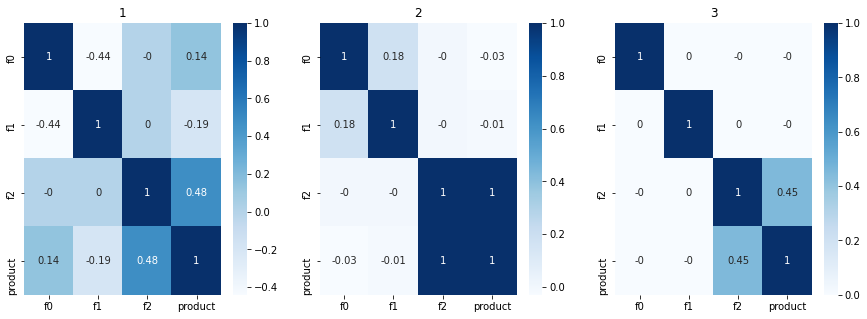

In [7]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
for data in [[data_1,1],[data_2,2],[data_3,3]]:
    plt.subplot(1, 3, data[1])
    sns.heatmap(data[0].corr().round(2), annot = True,cmap="Blues")
    plt.title(data[1])

>**ОГО!** Во втором датасете наблюдается сильная корреляция между признаком `f2` и `product`. В остальных датасетах корреляция меньше, но всё же имеется.

In [8]:
print('Количество уникальных значений id\nв первом: ', data_1['id'].nunique())
print('во втором: ', data_2['id'].nunique())
print('в третьем: ', data_3['id'].nunique())

Количество уникальных значений id
в первом:  99990
во втором:  99996
в третьем:  99996


In [9]:
print('Количество уникальных значений id\nв первом: ', data_1['product'].nunique())
print('во втором: ', data_2['product'].nunique())
print('в третьем: ', data_3['product'].nunique())

Количество уникальных значений id
в первом:  100000
во втором:  12
в третьем:  100000


> **Вывод:** итак, данные загружены, исследованы на  предмет пропусков, дубликатов и  других аномалий. В процессе подготовки не было выявлено ни пропусков, ни дубликатов, однако инетересным  мне показалась корреляция между `product`, `f2`. Тепловая карта показала среднюю/сильную зависимость этих двух столбцов, особенно во втором датасете. Также хочется отметить, что в столбце id не все уникальны, это значит, что проводилось несколько измерений на станциях. Что касается уникальных значений в product, то здесь всё интереснее: во втором датасете всего 12 уникальных значений, такое количество данных безусловно повлияет на все оценочные метрики и не даст правдоподобной картины. В целом данные готовы к дальнейшей работе и не требуют тщательной обработки.

Первый регион


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

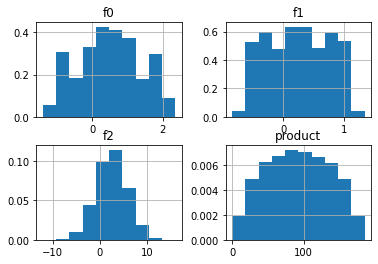

In [10]:
print('Первый регион')
data_1.hist(bins=10, density=True)

Второй регион


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

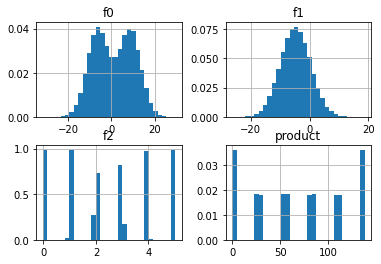

In [11]:
print('Второй регион')
data_2.hist(bins=30, density=True)

Третий регион


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

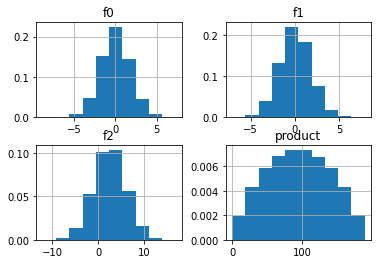

In [12]:
print('Третий регион')
data_3.hist(bins=10, density=True)

## Обучение и проверка модели

Обучим и проверим модель для каждого региона. Найдем средний запас предсказанного сырья и RMSE модели, еще интересно посмотреть на среднее сырья в target.

In [13]:
RANDOM_STATE = 12345
mean_pred = []
mean_target = []
rmse_region = []
model_score = []
data_target = []
data_pred  = []
for data in [data_1,data_2,data_3]:
    features = data.drop(['id','product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state = RANDOM_STATE)
    model = LinearRegression()
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    
    mean_pred.append(np.mean(predictions))#средний запас предсказанного сырья
    rmse_region.append(np.sqrt(mean_squared_error(target_valid, predictions)))#rmse
    mean_target.append(np.mean(data['product']))#среднее на всём product
    model_score.append(model.score(features_train,target_train))#score 
    
    data_target.append(target_valid)
    data_pred.append(predictions)

In [14]:
df_target = pd.DataFrame({'region_1':data_target[0],'region_2':data_target[1],'region_3':data_target[2]})
df_pred = pd.DataFrame({'region_1':data_pred[0],'region_2':data_pred[1],'region_3':data_pred[2]})

In [15]:
result_table = pd.DataFrame(data = [rmse_region,mean_pred,mean_target,model_score], index = ['rmse','mean_pred','mean_target','score'], columns = ['region_1','region_2','region_3'] )
result_table

,region_1,region_2,region_3
rmse,37.579422,0.893099,40.029709
mean_pred,92.592568,68.728547,94.965046
mean_target,92.500000,68.825000,95.000000
score,0.274239,0.999625,0.196614


> **Вывод:** как видим, у второй модели наименьшее *rmse*, а также наибольшая *score*, однако, как поняли раннее, в датасете второго региона всего 12 уникальных значений product, что безусловно влияет на результат. Плюс к этому у второго региона самый маленький средний объем сырья. Хочется также отметить, что среднее запас предсказанного сырья и средний запас сырья во всём датасете очень близки. Что же касается score для регионов 1,3, то здесь результаты очень низкие, что говорит о плохом качестве модели, обученной на этих данных. 

## Подготовка к расчёту прибыли

>При разведке региона исследуют 500 точек, выбирают 200 лучших, общий бюджет 10 млрд. Значит, в среднем на одну станцию нужно выделить A = 10 млрд/200. Далее мы знаем, что доход с каждой единицы продукта составляет 450000, значит *достаточный объём сырья для безубыточной разработки новой скважины* B >= A/450000.

In [17]:
volume_raw = BUDGET/(GOOD_POINTS*PRICE_PRODUCT)
volume_raw

111.11111111111111

In [18]:
result_table.loc[['mean_pred','mean_target'],:]

,region_1,region_2,region_3
mean_pred,92.592568,68.728547,94.965046
mean_target,92.500000,68.825000,95.000000


>Таким образом, достаточный объем сырья для безубыточной разработки новой скважины составил 111,1 тысяч баррелей, однако если мы сравним этот объем со средним объемом в каждом регионе, то увидим, что ни один регион не превышает (равен) 111.1.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

1) Выберем скважины с максимальными значениями предсказаний. 
2) Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3) Рассчитаем прибыль для полученного объёма сырья.
 

In [19]:
df_target = df_target.reset_index()
df_pred = df_pred.reset_index()

In [20]:
def profit(tar,pred):
    sort_pred = pred.sort_values(ascending=False)#сортируем по возрастанию
    select_points = tar[sort_pred.index][:GOOD_POINTS]#отбираем в таргете по индексам скважины с самым большим product
    return (PRICE_PRODUCT * select_points.sum() - BUDGET)

In [21]:
print('Прибыль для полученного объема сырья \n \nв регионе 1:',
      (profit(df_target['region_1'],df_pred['region_1'])/10**9).round(2), 'млрд.руб.')
print('\nв регионе 2:',(profit(df_target['region_2'],df_pred['region_2'])/10**9).round(2), 'млрд.руб.')
print('\nв регионе 3:',(profit(df_target['region_3'],df_pred['region_3'])/10**9).round(2), 'млрд.руб.')

Прибыль для полученного объема сырья 
 
в регионе 1: 3.32 млрд.руб.

в регионе 2: 2.42 млрд.руб.

в регионе 3: 2.71 млрд.руб.


## Расчёт прибыли и рисков 

Для каждого региона расчитаем среднюю прибыль, 95% доверительный интервал, а также риск убытка. Будем пользоваться техникой Bootstrap. Зададим 1000 подвыборок по 500 элементов в каждой.

In [22]:
mean_profit = []
interval = []
risks = []
state = np.random.RandomState(12345)
for i in range(1,4):
    profits = []
    for j in range(1000):
        target_subsample = df_target[f'region_{i}'].sample(n=500, replace=True, random_state=state)
        probs_subsample = df_pred[f'region_{i}'][target_subsample.index]
        profits.append(profit(target_subsample,probs_subsample))
    
    profits = pd.Series(profits)
    mean = (profits.mean()/10**9).round(2)
    lower = (profits.quantile(0.025)/10**9).round(2)
    upper = (profits.quantile(0.975)/10**9).round(2)
    inter = str((lower,upper))
    risk = ((profits<0).mean()*100).round(2)
    mean_profit.append(mean)
    interval.append(inter)
    risks.append(risk)
    

In [23]:
result = pd.DataFrame({'средняя прибыль, млрд.':mean_profit,'95% - д.интервал, млрд.': interval, 'риск, %':risks }, 
                      index = ['регион 1',' регион 2','регион 3'])
result

,"средняя прибыль, млрд.","95% - д.интервал, млрд.","риск, %"
регион 1,0.43,"(-0.1, 0.95)",6.0
регион 2,0.52,"(0.13, 0.95)",0.3
регион 3,0.42,"(-0.12, 0.99)",6.2


>**Вывод:** итак, рассчитав все необходимые показатели, можем навскидку сделать вывод, что второй регион наиболее прибыльный с наименьшим риском разорения. Однако!, как мы помним, во втором регионе слишком мало уникальных значений в product, а также неправдоподобно большая(гигантская) корреляция с признаком f2, поэтому считать регион 2 потенциальной территорией расположения скважины нельзя. Из оставшихся двух регионов лидириует первый, однако на текущий момент и его не следует выбирать, поскольку метрика score для него была очень низкой. Возможно, требуется больше данных по всем регионам, а также добавление других признаков, чтобы улучшить модель и проверить показатели региона 2 на правдоподобность.

## Общий вывод

Рассмотрена задача поиска оптимального места для бурения новой скважины. На начальном этапе проведен анализ трех датасетов на предмет пропусков, дубликатов, корреляций. Обработки данные не требовали. Выделяющимся оказался регион 2, в нем обнаружилось всего 12 уникальных значений в `product`, а также корреляция = 1 между целевым признаком и признаком f2.

Далее была построена модель машинного обучения с применением линейной регрессии и с целевым признаком `product`. По предсказанным данным рассчитан средний объем сырья в каждом регионе, оценена RMSE, а также метрика score. Результаты приведены ниже.

In [24]:
result_table

,region_1,region_2,region_3
rmse,37.579422,0.893099,40.029709
mean_pred,92.592568,68.728547,94.965046
mean_target,92.500000,68.825000,95.000000
score,0.274239,0.999625,0.196614


Как видим, в метрике score лидирует регион 2, а вот у регионов 1,3 значения много меньше. Эта аномалия описывалась выше. 

Далее был рассчитан минимальный объем сырья для безубыточной разработки новой скважины, он составил 111.1 баррелей, однако ни один из регионов не достигает этого уровня.

Также рассчитаны средняя прибыль и риски для каждого региона. По величине прибыли (0.52 млрд.) и малости риска (0.3%) лидирует регион 2, но как я отмечала выше, эти данные не стоит считать достоверными.

Таким образом, исследование указало на недостаточный объем данных. В таких условиях уверенный выбор оптимального региона сделать не получается.